# Trying to Transform Images via VQGAN

In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import imitools as I

In [2]:
device = "cuda"
I.defaults.device = device

In [3]:
# #getting CLIP
# !git clone https://github.com/openai/CLIPfrom_pretrained

In [4]:
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning

In [5]:
from CLIP import clip # The clip model
clip_model = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

In [6]:
def get_text_embs(text):
    return clip_model.encode_text(clip.tokenize(text).to(device))

def get_image_embs(pt_image):
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
    return clip_model.encode_image(normalize(pt_image))

In [7]:
# Let's use a different tool
# here lower values has a better match
def clip_loss(im_embed, text_embed):
    im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
    text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
    dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
    return dists.mean()

In [8]:
# # cloning the repo
# !git clone https://github.com/CompVis/taming-transformers &> /dev/null

In [9]:
!pip install -q einops ftfy==6.1.1 regex==2022.4.24 tqdm==4.64.0 omegaconf==2.2.1 pytorch-lightning==1.6.3 &> /dev/null
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

In [10]:
from pathlib import Path
base_data_path = Path.home()/"data/vqgan"
base_data_path.mkdir(exist_ok=True, parents=True)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [11]:
# # loading imagenet weights
# !cd {base_data_path} && curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
# !cd {base_data_path} && curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

In [12]:
import torch
import torch.nn.functional as F

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply

class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

def synth(model, z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(model, width, height):
    f = 2**(model.decoder.num_resolutions - 1)
    toksX, toksY = width // f, height // f
    n_toks = model.quantize.n_e
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
    return z

In [13]:
vqgan_model = load_vqgan_model(base_data_path/'vqgan_imagenet_f16_16384.yaml', base_data_path/'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


8.19kB [00:00, 350kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from /home/data/vqgan/vqgan_imagenet_f16_16384.ckpt


## Training with Mixing Images

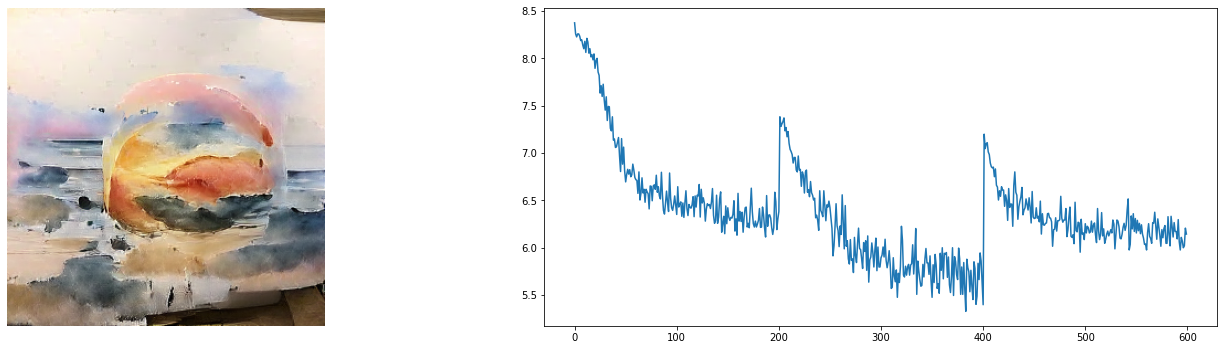

  0%|          | 0/600 [00:00<?, ?it/s]

In [14]:
prompt = "Watercolor painting of a cat trending on ArtStation"
prompt2 = "Watercolor painting of a soccer ball trending on ArtStation"
prompt3 = "Watercolor painting of a sunset at the beach trending on ArtStation"
steps = 600
n_variations = 10

apply_transformations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])
def calc_loss(a, b): return 1.0 - torch.nn.CosineSimilarity()(a, b)
text_embs = get_text_embs(prompt).to(device)

latents = rand_z(vqgan_model, 300, 300)
latents.requires_grad_()

optimizer = torch.optim.Adam([latents], lr=0.1)

losses = []
gen_images = []
plotter = I.dplot(cols=2)

for i in tqdm(range(steps)):
    optimizer.zero_grad()
    
    gen_image = synth(vqgan_model, latents)
    loss = 0
    
    for _ in range(n_variations):
        img_embs = get_image_embs(apply_transformations(gen_image)).to(device)
        loss += calc_loss(text_embs, img_embs)
    
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
    if i == 200:
        text_embs = get_text_embs(prompt2).to(device)
        
    if i == 400:
        text_embs = get_text_embs(prompt3).to(device)
        
    if i % 5:
        gen_images.append(gen_image)
    
    if i % 20 == 0 or i == steps-1:
        plotter.imshow(0, gen_image)
        plotter.plot(1, losses)
        plotter.update()
    
plotter.close()

In [15]:
# install ffmpeg
!apt update -y > /dev/null 2>&1
!DEBIAN_FRONTEND=noninteractive apt -y install ffmpeg > /dev/null 2>&1

In [22]:
I.wrap(gen_images).cpil().to_video(frame_rate=24).show()